In [23]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import io

from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
from museko.essentia_model.genre_data import genre_names

import ipywidgets as widgets
from IPython.display import display

In [16]:
def classify(filename):
    
    base_dir = os.getcwd()
    effnet_model_path = os.path.join(base_dir, "museko/essentia_model/discogs-effnet-bs64-1.pb")
    genre_model_path = os.path.join(base_dir, "museko/essentia_model/genre_discogs400-discogs-effnet-1.pb")

    if not os.path.exists(effnet_model_path):
        raise FileNotFoundError(f"Effnet model file not found at {effnet_model_path}")
    if not os.path.exists(genre_model_path):
        raise FileNotFoundError(f"Genre model file not found at {genre_model_path}")
    
    audio = MonoLoader(filename=filename, sampleRate=16000, resampleQuality=4)()

    # Extract embeddings
    embedding_model = TensorflowPredictEffnetDiscogs(
        graphFilename=effnet_model_path,
        output="PartitionedCall:1"
    )
    embeddings = embedding_model(audio)

    # Predict with genre classification model
    model = TensorflowPredict2D(
        graphFilename=genre_model_path,
        input="serving_default_model_Placeholder", 
        output="PartitionedCall:0"
    )
    predictions = model(embeddings)
    average_predictions = np.mean(predictions, axis=0)

    # Sort genres by average prediction scores
    sorted_indices = np.argsort(average_predictions)[::-1]  # Descending order
    sorted_genres = [genre_names[i] for i in sorted_indices]
    sorted_predictions = average_predictions[sorted_indices]

    # Select top N genres to display
    top_n = 10
    top_genres = sorted_genres[:top_n]
    top_scores = sorted_predictions[:top_n]

    # UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
    # only run this line for local MacOS file
    # plt.switch_backend('Agg') 

    return [top_n, top_genres, top_scores]

In [29]:
def on_file_upload(change):
    global file_path
    
    uploaded_files = change['new']
    if uploaded_files:
        for file_info in uploaded_files:
            filename = file_info['name']
            file_path = os.getcwd() + "/jupytermp3/" + filename

In [34]:
# File upload widget. Important: Place the mp3 in the "jupytermp3" directory.
upload_widget = widgets.FileUpload(accept='.mp3', multiple=False)
upload_widget.observe(on_file_upload, names='value')

display(upload_widget)

FileUpload(value=(), accept='.mp3', description='Upload')

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `/Users/brianmai/Desktop/code/Museko/museko/essentia_model/discogs-effnet-bs64-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `/Users/brianmai/Desktop/code/Museko/museko/essentia_model/genre_discogs400-discogs-effnet-1.pb`
[   INFO   ] TensorflowPredict: Successfully loaded graph file: `/Users/brianmai/Desktop/code/Museko/museko/essentia_model/genre_discogs400-discogs-effnet-1.pb`


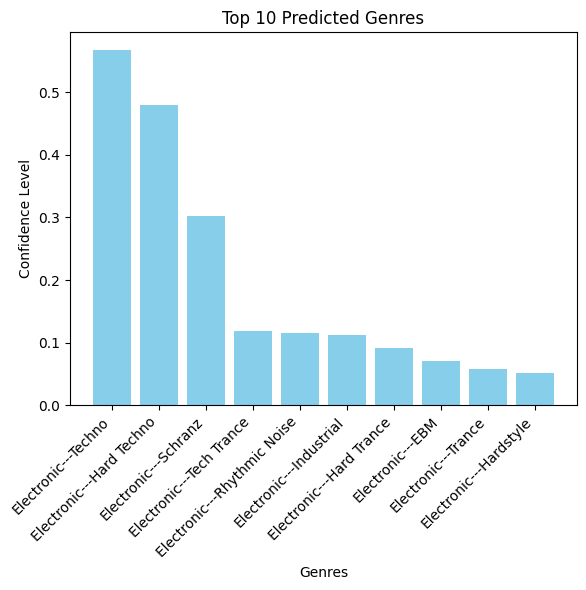

In [35]:
# Need to upload the mp3 in the widget above before running this cell.

top_n, top_genres, top_scores = classify(file_path)

plt.figure(figsize=(6, 6))
plt.bar(top_genres, top_scores, color='skyblue')
plt.xlabel('Genres')

# Average prediction scores = Confidence Level C, if taking many samples the score approaches C
plt.ylabel('Confidence Level')
plt.title(f'Top {top_n} Predicted Genres')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()